In [8]:
# make the necessary imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
idx = pd.IndexSlice
import statsmodels.api as sm

from statsmodels.regression.linear_model import OLS
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import coint
from sklearn.model_selection import train_test_split

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

### Identification of Cointegrated Pairs of Stocks

In [9]:
# read back the pricing data
prices = pd.read_csv('psu_banks.csv', index_col=['date'])
prices.head(10)

SBIN.NS  BANKBARODA.NS    CANBK.NS      PNB.NS  UNIONBANK.NS  \
date                                                                          
01-01-2018  307.100006     161.500000  360.700012  169.750000    144.899994   
02-01-2018  303.250000     157.949997  352.049988  166.399994    141.949997   
03-01-2018  302.850006     157.850006  352.799988  166.600006    143.149994   
04-01-2018  308.500000     163.899994  362.549988  176.449997    147.500000   
05-01-2018  306.350006     161.800003  364.850006  176.000000    145.300003   
08-01-2018  305.799988     161.649994  364.750000  175.699997    145.649994   
09-01-2018  304.299988     164.500000  364.700012  174.649994    144.100006   
10-01-2018  301.100006     162.500000  354.649994  170.649994    141.750000   
11-01-2018  302.200012     163.300003  355.500000  172.750000    138.800003   
12-01-2018  302.250000     163.000000  353.950012  174.199997    137.600006   

            BANKINDIA.NS  INDIANB.NS     IOB.NS  CENTRALBK.NS  MAHABANK.NS  
date                                                                        
01-01-2018    169.899994  377.149994  22.450001     74.699997    23.299999  
02-01-2018    167.300003  375.549988  22.350000     74.949997    22.950001  
03-01-2018    168.350006  373.200012  22.500000     75.900002    23.049999  
04-01-2018    174.649994  380.149994  23.049999     76.750000    23.600000  
05-01-2018    172.250000  379.250000  24.150000     76.050003    23.650000  
08-01-2018    170.399994  380.700012  23.950001     75.449997    23.549999  
09-01-2018    170.250000  377.950012  23.950001     74.900002    23.250000  
10-01-2018    165.000000  373.450012  23.549999     74.699997    22.750000  
11-01-2018    166.050003  370.899994  23.350000     74.699997    22.450001  
12-01-2018    162.649994  374.250000  23.500000     75.000000    22.400000

In [10]:
# train test split 
train_close, test_close = train_test_split(prices, test_size=0.251012, shuffle=False)

In [11]:
# quick view of head and tail of train set
train_close.head(2).append(train_close.tail(2))

SBIN.NS  BANKBARODA.NS    CANBK.NS      PNB.NS  UNIONBANK.NS  \
date                                                                          
01-01-2018  307.100006     161.500000  360.700012  169.750000    144.899994   
02-01-2018  303.250000     157.949997  352.049988  166.399994    141.949997   
30-12-2020  276.899994      62.099998  129.350006   32.750000     31.950001   
31-12-2020  274.950012      61.450001  128.949997   33.049999     31.549999   

            BANKINDIA.NS  INDIANB.NS     IOB.NS  CENTRALBK.NS  MAHABANK.NS  
date                                                                        
01-01-2018    169.899994  377.149994  22.450001     74.699997    23.299999  
02-01-2018    167.300003  375.549988  22.350000     74.949997    22.950001  
30-12-2020     49.200001   87.050003  10.500000     13.750000    13.050000  
31-12-2020     48.700001   85.699997  10.700000     13.850000    13.050000

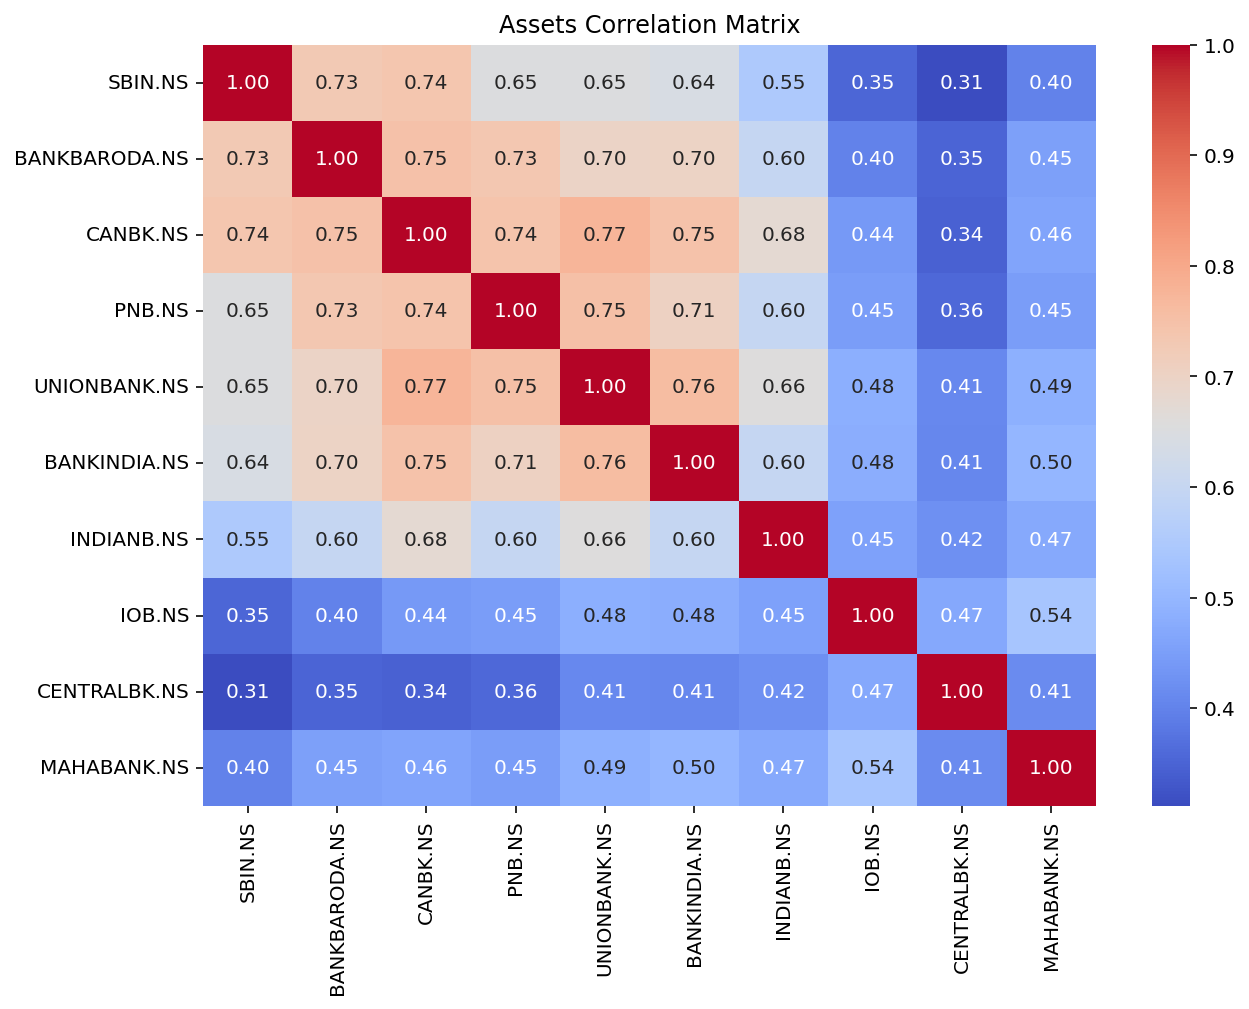

In [12]:
# Pearson correlation to get the basic idea about the relationship
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(train_close.pct_change().corr(method ='pearson'), ax=ax, cmap='coolwarm', annot=True, fmt=".2f") #spearman
ax.set_title('Assets Correlation Matrix')
plt.savefig('chart1', dpi=400)

In [13]:
# function to find cointegrated pairs
def find_cointegrated_pairs(data):
    n = data.shape[1]
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            result = coint(data[keys[i]], data[keys[j]])
            pvalue_matrix[i, j] = result[1]
            if result[1] < 0.05:
                pairs.append((keys[i], keys[j]))
    return pvalue_matrix, pairs

[('BANKBARODA.NS', 'UNIONBANK.NS'), ('BANKBARODA.NS', 'BANKINDIA.NS'), ('PNB.NS', 'UNIONBANK.NS'), ('PNB.NS', 'BANKINDIA.NS'), ('PNB.NS', 'INDIANB.NS'), ('PNB.NS', 'CENTRALBK.NS'), ('UNIONBANK.NS', 'BANKINDIA.NS'), ('UNIONBANK.NS', 'INDIANB.NS'), ('BANKINDIA.NS', 'INDIANB.NS')]


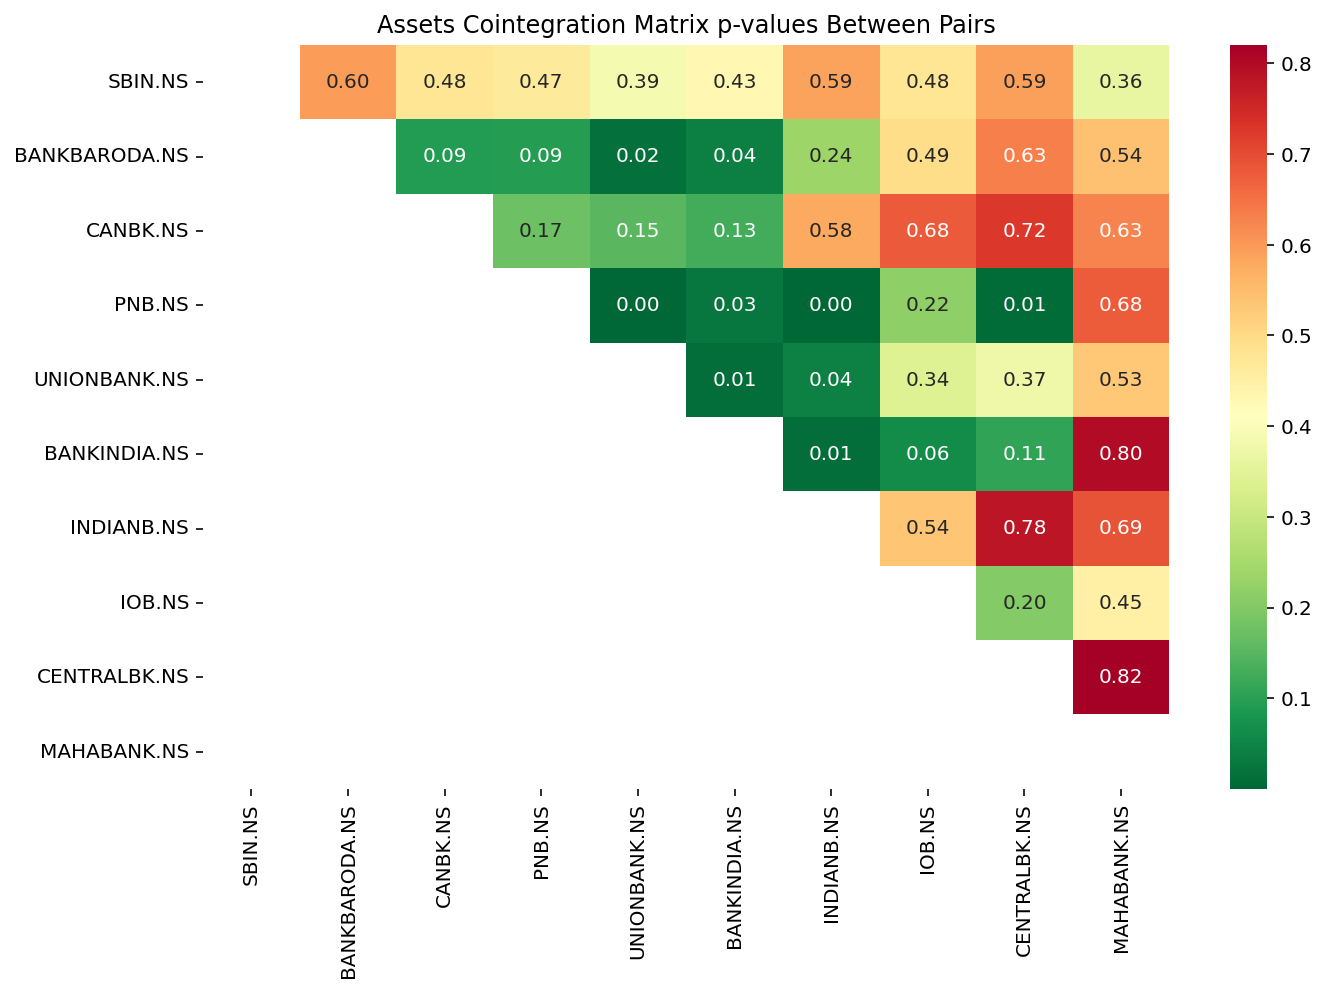

In [14]:
# calculate p-values and plot as a heatmap
pvalues, pairs = find_cointegrated_pairs(train_close)
print(pairs)
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(pvalues, xticklabels = train_close.columns,
                yticklabels = train_close.columns, cmap = 'RdYlGn_r', annot = True, fmt=".2f",
                mask = (pvalues >= 0.99))
ax.set_title('Assets Cointegration Matrix p-values Between Pairs')
plt.tight_layout()
plt.savefig('chart2', dpi=400) 

### Perform a Cointegration test for the Selected Pair

In [15]:
# final pair to test strategy
asset1 = 'UNIONBANK.NS'
asset2 = 'BANKINDIA.NS'

In [16]:
# create a train dataframe of 2 assets
train = pd.DataFrame()
train['asset1'] = train_close[asset1]
train['asset2'] = train_close[asset2]

In [17]:
from matplotlib.dates import DateFormatter
# visualize closing prices
ax = train[['asset1','asset2']].plot(figsize=(20, 10), title = 'Daily Closing Prices for {} and {}'.format(asset1,asset2))
ax.set_ylabel("Closing Price")
#date_form = DateFormatter("%Y")
# ax.xaxis.set_major_formatter(date_form)
ax.grid(True);
plt.savefig('chart3', dpi=400) 

In [18]:
# run OLS regression
model=sm.OLS(train.asset2, train.asset1).fit()

In [19]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                 asset2   R-squared (uncentered):                   0.992
Model:                            OLS   Adj. R-squared (uncentered):              0.992
Method:                 Least Squares   F-statistic:                          8.806e+04
Date:                Tue, 22 Mar 2022   Prob (F-statistic):                        0.00
Time:                        20:26:03   Log-Likelihood:                         -2540.4
No. Observations:                 740   AIC:                                      5083.
Df Residuals:                     739   BIC:                                      5087.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
asset1         1.1521      0.004    296.741      0.000       1.144       1.160
==============================================================================
Omnibus:                      129.703   Durbin-Watson:                   0.038
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               34.586
Skew:                           0.229   Prob(JB):                     3.09e-08
Kurtosis:                       2.045   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [20]:
# print regression summary results
plt.rc('figure', figsize=(12, 7))
plt.text(0.01, 0.05, str(model.summary()), {'fontsize': 16}, fontproperties = 'monospace')
plt.axis('off')
plt.tight_layout()
plt.subplots_adjust(left=0.2, right=0.8, top=0.7, bottom=0.1)
plt.savefig('chart4', dpi=400);

In [21]:
print('Hedge Ratio = ', model.params[0])

Hedge Ratio =  1.1520656635913655


In [22]:
# calculate spread
spread = train.asset2 - model.params[0] * train.asset1

In [23]:
# Plot the spread
ax = spread.plot(figsize=(12, 6), title = "Pair's Spread")
ax.set_ylabel("Spread")
ax.grid(True);
plt.savefig('chart5', dpi=400);

In [24]:
# conduct Augmented Dickey-Fuller test
adf = adfuller(spread, maxlag = 1)
adf

(-2.4042332746133237,
 0.14054516134345202,
 1,
 738,
 {'1%': -3.4392418578608983,
  '5%': -2.86546426916434,
  '10%': -2.568859710342903},
 2651.2480608958595)

In [25]:
print('Critical Value = ', adf[0])

Critical Value =  -2.4042332746133237


In [26]:
# probablity critical values
print(adf[4])

{'1%': -3.4392418578608983, '5%': -2.86546426916434, '10%': -2.568859710342903}


### Generate Trading Signals using z-score

In [27]:
# calculate z-score
def zscore(series):
    return (series - series.mean()) / np.std(series)

In [28]:
# create a dataframe for trading signals
signals = pd.DataFrame()
signals['asset1'] = test_close[asset1] 
signals['asset2'] = test_close[asset2]
ratios = signals.asset1 / signals.asset2

In [29]:
signals.head()

asset1     asset2
date                            
01-01-2021  32.099998  50.150002
04-01-2021  32.400002  50.349998
05-01-2021  32.049999  50.549999
06-01-2021  31.850000  51.200001
07-01-2021  31.900000  51.150002

In [30]:
# calculate z-score and define upper and lower thresholds
signals['z'] = zscore(ratios)
signals['z upper limit'] = np.mean(signals['z']) + np.std(signals['z'])
signals['z lower limit'] = np.mean(signals['z']) - np.std(signals['z'])

In [31]:
signals.head()

asset1     asset2         z  z upper limit  z lower limit
date                                                                    
01-01-2021  32.099998  50.150002  0.349526            1.0           -1.0
04-01-2021  32.400002  50.349998  0.375832            1.0           -1.0
05-01-2021  32.049999  50.549999  0.302904            1.0           -1.0
06-01-2021  31.850000  51.200001  0.210835            1.0           -1.0
07-01-2021  31.900000  51.150002  0.223046            1.0           -1.0

In [32]:
# create signal - short if z-score is greater than upper limit else long
signals['signals1'] = 0
signals['signals1'] = np.select([signals['z'] > \
                                 signals['z upper limit'], signals['z'] < signals['z lower limit']], [-1, 1], default=0)

In [33]:
# we take the first order difference to obtain portfolio position in that stock
signals['positions1'] = signals['signals1'].diff()
signals['signals2'] = -signals['signals1']
signals['positions2'] = signals['signals2'].diff()

In [34]:
# # visualize z-score and upper and lower thresholds   
signals['z'].plot(label="z Value")
plt.title("Z-score Evaluation")
plt.axhline(signals['z'].mean(),color="black")
plt.axhline(signals['z upper limit'].mean(), color="red", label="Upper Threshold")
plt.axhline(signals['z lower limit'].mean(), color="green", label="Lower Threshold")
plt.legend()
plt.tight_layout()
plt.savefig('chart6', dpi=400);

In [35]:
# verify dataframe head and tail
signals.head(3).append(signals.tail(3))

asset1     asset2         z  z upper limit  z lower limit  \
date                                                                       
01-01-2021  32.099998  50.150002  0.349526            1.0           -1.0   
04-01-2021  32.400002  50.349998  0.375832            1.0           -1.0   
05-01-2021  32.049999  50.549999  0.302904            1.0           -1.0   
29-12-2021  43.549999  51.349998  1.951504            1.0           -1.0   
30-12-2021  42.799999  50.849998  1.902140            1.0           -1.0   
31-12-2021  43.400002  51.400002  1.922677            1.0           -1.0   

            signals1  positions1  signals2  positions2  
date                                                    
01-01-2021         0         NaN         0         NaN  
04-01-2021         0         0.0         0         0.0  
05-01-2021         0         0.0         0         0.0  
29-12-2021        -1         0.0         1         0.0  
30-12-2021        -1         0.0         1         0.0  
31-12-2021        -1         0.0         1         0.0

In [36]:
# # check portfolio position
signals[signals.signals1 != 0].head(10)

asset1     asset2         z  z upper limit  z lower limit  \
date                                                                       
17-02-2021  38.099998  84.699997 -1.115645            1.0           -1.0   
18-02-2021  42.049999  93.150002 -1.103327            1.0           -1.0   
22-02-2021  39.349998  87.199997 -1.104566            1.0           -1.0   
23-02-2021  38.750000  83.550003 -1.008052            1.0           -1.0   
25-05-2021  35.000000  77.000000 -1.079276            1.0           -1.0   
26-05-2021  34.099998  76.900002 -1.164854            1.0           -1.0   
27-05-2021  33.950001  77.000000 -1.184290            1.0           -1.0   
28-05-2021  34.349998  77.550003 -1.168650            1.0           -1.0   
31-05-2021  34.700001  77.199997 -1.118271            1.0           -1.0   
01-06-2021  34.349998  76.199997 -1.108217            1.0           -1.0   

            signals1  positions1  signals2  positions2  
date                                                    
17-02-2021         1         1.0        -1        -1.0  
18-02-2021         1         0.0        -1         0.0  
22-02-2021         1         1.0        -1        -1.0  
23-02-2021         1         0.0        -1         0.0  
25-05-2021         1         1.0        -1        -1.0  
26-05-2021         1         0.0        -1         0.0  
27-05-2021         1         0.0        -1         0.0  
28-05-2021         1         0.0        -1         0.0  
31-05-2021         1         0.0        -1         0.0  
01-06-2021         1         0.0        -1         0.0

In [37]:
signals[signals.positions1 != 0].head().append(signals[signals.positions1 != 0].tail())

asset1     asset2         z  z upper limit  z lower limit  \
date                                                                       
01-01-2021  32.099998  50.150002  0.349526            1.0           -1.0   
17-02-2021  38.099998  84.699997 -1.115645            1.0           -1.0   
19-02-2021  40.500000  84.300003 -0.879962            1.0           -1.0   
22-02-2021  39.349998  87.199997 -1.104566            1.0           -1.0   
24-02-2021  40.900002  87.150002 -0.965607            1.0           -1.0   
22-02-2021  39.349998  87.199997 -1.104566            1.0           -1.0   
24-02-2021  40.900002  87.150002 -0.965607            1.0           -1.0   
25-05-2021  35.000000  77.000000 -1.079276            1.0           -1.0   
14-06-2021  37.400002  79.199997 -0.943147            1.0           -1.0   
13-10-2021  44.400002  59.250000  1.191150            1.0           -1.0   

            signals1  positions1  signals2  positions2  
date                                                    
01-01-2021         0         NaN         0         NaN  
17-02-2021         1         1.0        -1        -1.0  
19-02-2021         0        -1.0         0         1.0  
22-02-2021         1         1.0        -1        -1.0  
24-02-2021         0        -1.0         0         1.0  
22-02-2021         1         1.0        -1        -1.0  
24-02-2021         0        -1.0         0         1.0  
25-05-2021         1         1.0        -1        -1.0  
14-06-2021         0        -1.0         0         1.0  
13-10-2021        -1        -1.0         1         1.0

In [38]:
signals.loc[signals['positions1'] == 1].index
signals['asset1'][signals['positions1'] == 1].value_counts()

38.099998    1
39.349998    1
35.000000    1
Name: asset1, dtype: int64

In [39]:
signals

asset1     asset2         z  z upper limit  z lower limit  \
date                                                                       
01-01-2021  32.099998  50.150002  0.349526            1.0           -1.0   
04-01-2021  32.400002  50.349998  0.375832            1.0           -1.0   
05-01-2021  32.049999  50.549999  0.302904            1.0           -1.0   
06-01-2021  31.850000  51.200001  0.210835            1.0           -1.0   
07-01-2021  31.900000  51.150002  0.223046            1.0           -1.0   
...               ...        ...       ...            ...            ...   
27-12-2021  42.950001  51.099998  1.893034            1.0           -1.0   
28-12-2021  44.150002  51.349998  2.041487            1.0           -1.0   
29-12-2021  43.549999  51.349998  1.951504            1.0           -1.0   
30-12-2021  42.799999  50.849998  1.902140            1.0           -1.0   
31-12-2021  43.400002  51.400002  1.922677            1.0           -1.0   

            signals1  positions1  signals2  positions2  
date                                                    
01-01-2021         0         NaN         0         NaN  
04-01-2021         0         0.0         0         0.0  
05-01-2021         0         0.0         0         0.0  
06-01-2021         0         0.0         0         0.0  
07-01-2021         0         0.0         0         0.0  
...              ...         ...       ...         ...  
27-12-2021        -1         0.0         1         0.0  
28-12-2021        -1         0.0         1         0.0  
29-12-2021        -1         0.0         1         0.0  
30-12-2021        -1         0.0         1         0.0  
31-12-2021        -1         0.0         1         0.0  

[248 rows x 9 columns]

In [40]:
signals = signals.reset_index()

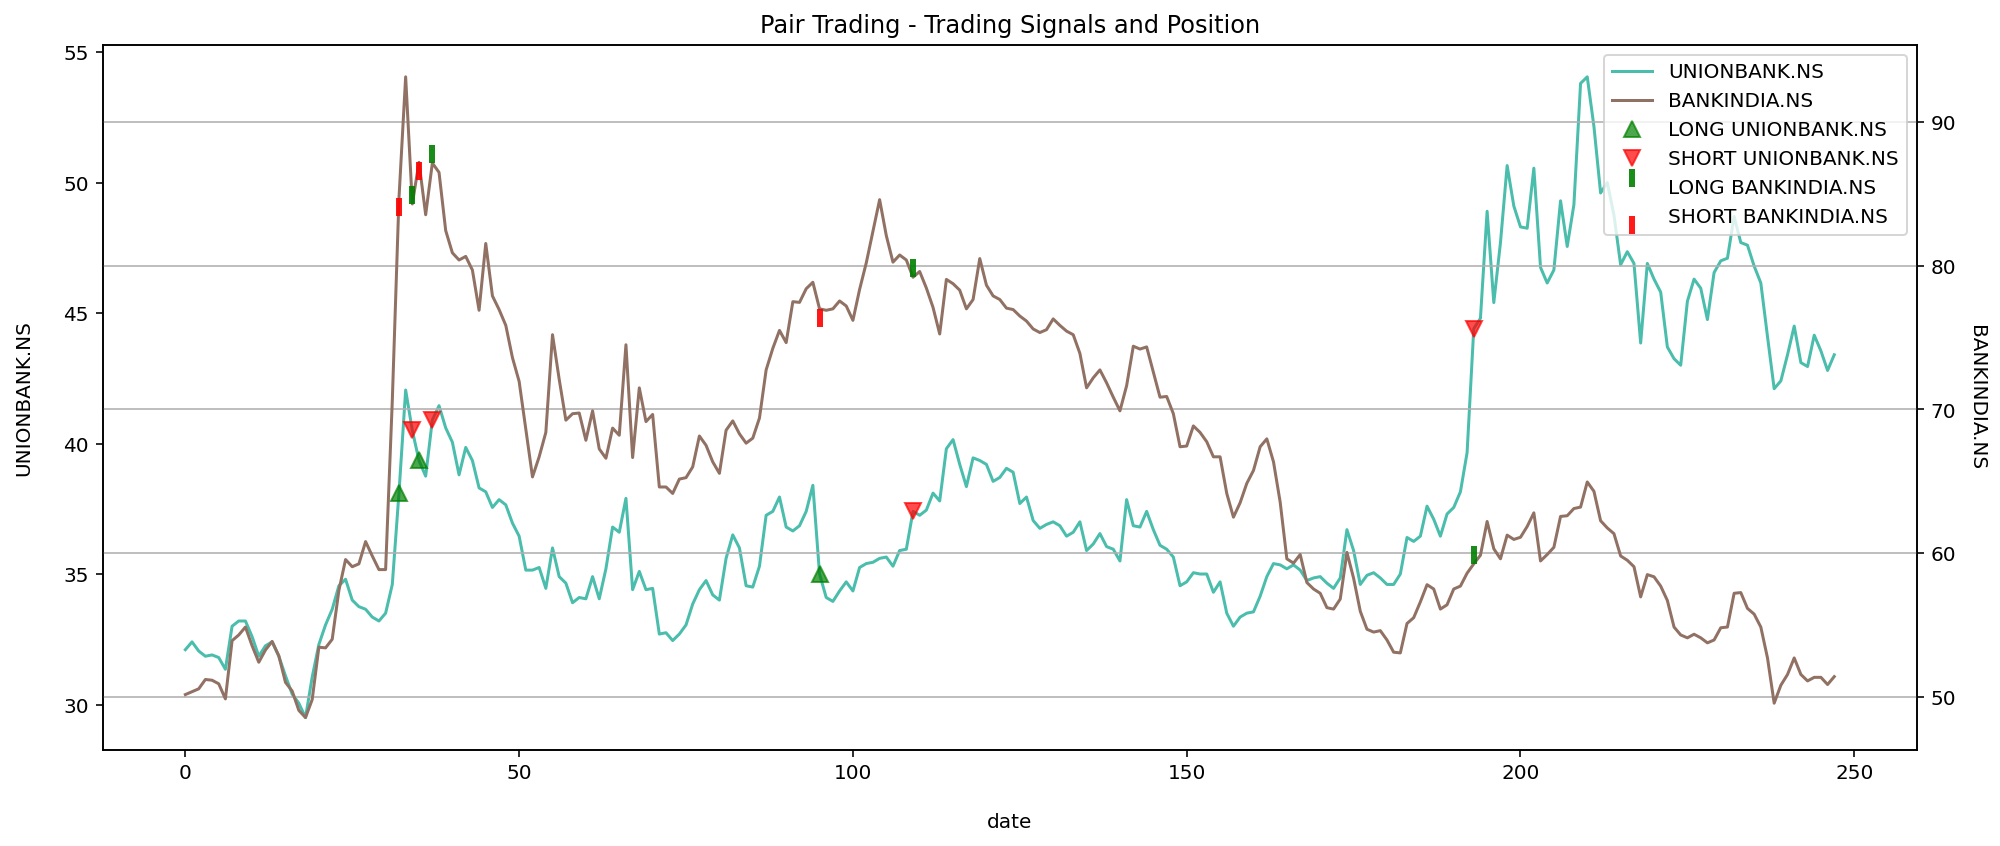

In [41]:
# visualize trading signals and position
fig=plt.figure(figsize=(14,6))
bx = fig.add_subplot(111)   
bx2 = bx.twinx()

#plot two different assets
l1, = bx.plot(signals['asset1'], c='#4abdac')
l2, = bx2.plot(signals['asset2'], c='#907163')

u1, = bx.plot(signals['asset1'][signals['positions1'] == 1], lw=0, marker='^', markersize=8, c='g',alpha=0.7)

d1, = bx.plot(signals['asset1'][signals['positions1'] == -1], lw=0,marker='v',markersize=8, c='r',alpha=0.7)

u2, = bx2.plot(signals['asset2'][signals['positions2'] == 1], lw=0,marker=2,markersize=9, c='g',alpha=0.9, markeredgewidth=3)

d2, = bx2.plot(signals['asset2'][signals['positions2'] == -1], lw=0,marker=3,markersize=9, c='r',alpha=0.9,markeredgewidth=3)

bx.set_ylabel(asset1,)
bx2.set_ylabel(asset2, rotation=270)
bx.yaxis.labelpad=15
bx2.yaxis.labelpad=15
bx.set_xlabel('date')
# bx.xaxis.set_major_formatter(DateFormatter("%Y"))
# bx2.xaxis.set_major_formatter(DateFormatter("%Y"))
bx.xaxis.labelpad=15

plt.legend([l1,l2,u1,d1,u2,d2], [asset1, asset2,'LONG {}'.format(asset1),
           'SHORT {}'.format(asset1),
           'LONG {}'.format(asset2),
           'SHORT {}'.format(asset2)], loc ='best')

plt.title('Pair Trading - Trading Signals and Position')
plt.xlabel('Date')
plt.grid(True)
plt.tight_layout()
plt.savefig('chart7', dpi=400);

### Portfolio Profit and Loss Calculation

In [42]:
# initial capital to calculate the actual pnl
initial_capital = 100000

# shares to buy for each position
positions1 = initial_capital// max(signals['asset1'])
positions2 = initial_capital// max(signals['asset2'])

In [43]:
# since there are two assets, we calculate each asset Pnl separately 
# and in the end we aggregate them into one portfolio
portfolio = pd.DataFrame()
portfolio['asset1'] = signals['asset1']
portfolio['holdings1'] = signals['positions1'].cumsum() * signals['asset1'] * positions1
portfolio['cash1'] = initial_capital - (signals['positions1'] * signals['asset1'] * positions1).cumsum()
portfolio['total asset1'] = portfolio['holdings1'] + portfolio['cash1']
portfolio['return1'] = portfolio['total asset1'].pct_change()
portfolio['positions1'] = signals['positions1']

In [44]:
portfolio.head().append(portfolio.tail())

asset1     holdings1          cash1   total asset1   return1  \
0    32.099998           NaN            NaN            NaN       NaN   
1    32.400002      0.000000  100000.000000  100000.000000       NaN   
2    32.049999      0.000000  100000.000000  100000.000000  0.000000   
3    31.850000      0.000000  100000.000000  100000.000000  0.000000   
4    31.900000      0.000000  100000.000000  100000.000000  0.000000   
243  42.950001 -79457.501406  193887.514153  114430.012747  0.002431   
244  44.150002 -81677.502831  193887.514153  112210.011322 -0.019401   
245  43.549999 -80567.498594  193887.514153  113320.015559  0.009892   
246  42.799999 -79179.998594  193887.514153  114707.515559  0.012244   
247  43.400002 -80290.002831  193887.514153  113597.511322 -0.009677   

     positions1  
0           NaN  
1           0.0  
2           0.0  
3           0.0  
4           0.0  
243         0.0  
244         0.0  
245         0.0  
246         0.0  
247         0.0

In [45]:
portfolio[portfolio.positions1 != 0].head()

asset1     holdings1          cash1   total asset1   return1  \
0   32.099998           NaN            NaN            NaN       NaN   
32  38.099998  70484.997169   29515.002831  100000.000000  0.000000   
34  40.500000      0.000000  104440.002831  104440.002831 -0.026722   
35  39.349998  72797.497169   31642.505661  104440.002831  0.000000   
37  40.900002      0.000000  107307.508492  107307.508492  0.038493   

    positions1  
0          NaN  
32         1.0  
34        -1.0  
35         1.0  
37        -1.0

In [46]:
# pnl for the 2nd asset
portfolio['asset2'] = signals['asset2']
portfolio['holdings2'] = signals['positions2'].cumsum() * signals['asset2'] * positions2
portfolio['cash2'] = initial_capital - (signals['positions2'] * signals['asset2'] * positions2).cumsum()
portfolio['total asset2'] = portfolio['holdings2'] + portfolio['cash2']
portfolio['return2'] = portfolio['total asset2'].pct_change()
portfolio['positions2'] = signals['positions2']

In [47]:
portfolio.to_csv('portfolio.csv')
portfolio.head().append(portfolio.tail())

asset1     holdings1          cash1   total asset1   return1  \
0    32.099998           NaN            NaN            NaN       NaN   
1    32.400002      0.000000  100000.000000  100000.000000       NaN   
2    32.049999      0.000000  100000.000000  100000.000000  0.000000   
3    31.850000      0.000000  100000.000000  100000.000000  0.000000   
4    31.900000      0.000000  100000.000000  100000.000000  0.000000   
243  42.950001 -79457.501406  193887.514153  114430.012747  0.002431   
244  44.150002 -81677.502831  193887.514153  112210.011322 -0.019401   
245  43.549999 -80567.498594  193887.514153  113320.015559  0.009892   
246  42.799999 -79179.998594  193887.514153  114707.515559  0.012244   
247  43.400002 -80290.002831  193887.514153  113597.511322 -0.009677   

     positions1     asset2     holdings2          cash2   total asset2  \
0           NaN  50.150002           NaN            NaN            NaN   
1           0.0  50.349998      0.000000  100000.000000  100000.000000   
2           0.0  50.549999      0.000000  100000.000000  100000.000000   
3           0.0  51.200001      0.000000  100000.000000  100000.000000   
4           0.0  51.150002      0.000000  100000.000000  100000.000000   
243         0.0  51.099998  54830.298358   34546.991813   89377.290171   
244         0.0  51.349998  55098.548358   34546.991813   89645.540171   
245         0.0  51.349998  55098.548358   34546.991813   89645.540171   
246         0.0  50.849998  54562.048358   34546.991813   89109.040171   
247         0.0  51.400002  55152.201642   34546.991813   89699.193455   

      return2  positions2  
0         NaN         NaN  
1         NaN         0.0  
2    0.000000         0.0  
3    0.000000         0.0  
4    0.000000         0.0  
243 -0.005373         0.0  
244  0.003001         0.0  
245  0.000000         0.0  
246 -0.005985         0.0  
247  0.006623         0.0

In [48]:
portfolio[portfolio.positions2 != 0].head()

asset1     holdings1          cash1   total asset1   return1  \
0   32.099998           NaN            NaN            NaN       NaN   
32  38.099998  70484.997169   29515.002831  100000.000000  0.000000   
34  40.500000      0.000000  104440.002831  104440.002831 -0.026722   
35  39.349998  72797.497169   31642.505661  104440.002831  0.000000   
37  40.900002      0.000000  107307.508492  107307.508492  0.038493   

    positions1     asset2     holdings2          cash2   total asset2  \
0          NaN  50.150002           NaN            NaN            NaN   
32         1.0  84.699997 -90883.096727  190883.096727  100000.000000   
34        -1.0  84.300003      0.000000  100429.193455  100429.193455   
35         1.0  87.199997 -93565.596727  193994.790182  100429.193455   
37        -1.0  87.150002      0.000000  100482.838540  100482.838540   

     return2  positions2  
0        NaN         NaN  
32  0.000000        -1.0  
34  0.104429         1.0  
35  0.000000        -1.0  
37 -0.037019         1.0

In [49]:
# total pnl and z-score
portfolio['z'] = signals['z']
portfolio['total asset'] = portfolio['total asset1'] + portfolio['total asset2']
portfolio['z upper limit'] = signals['z upper limit']
portfolio['z lower limit'] = signals['z lower limit']
portfolio = portfolio.dropna()

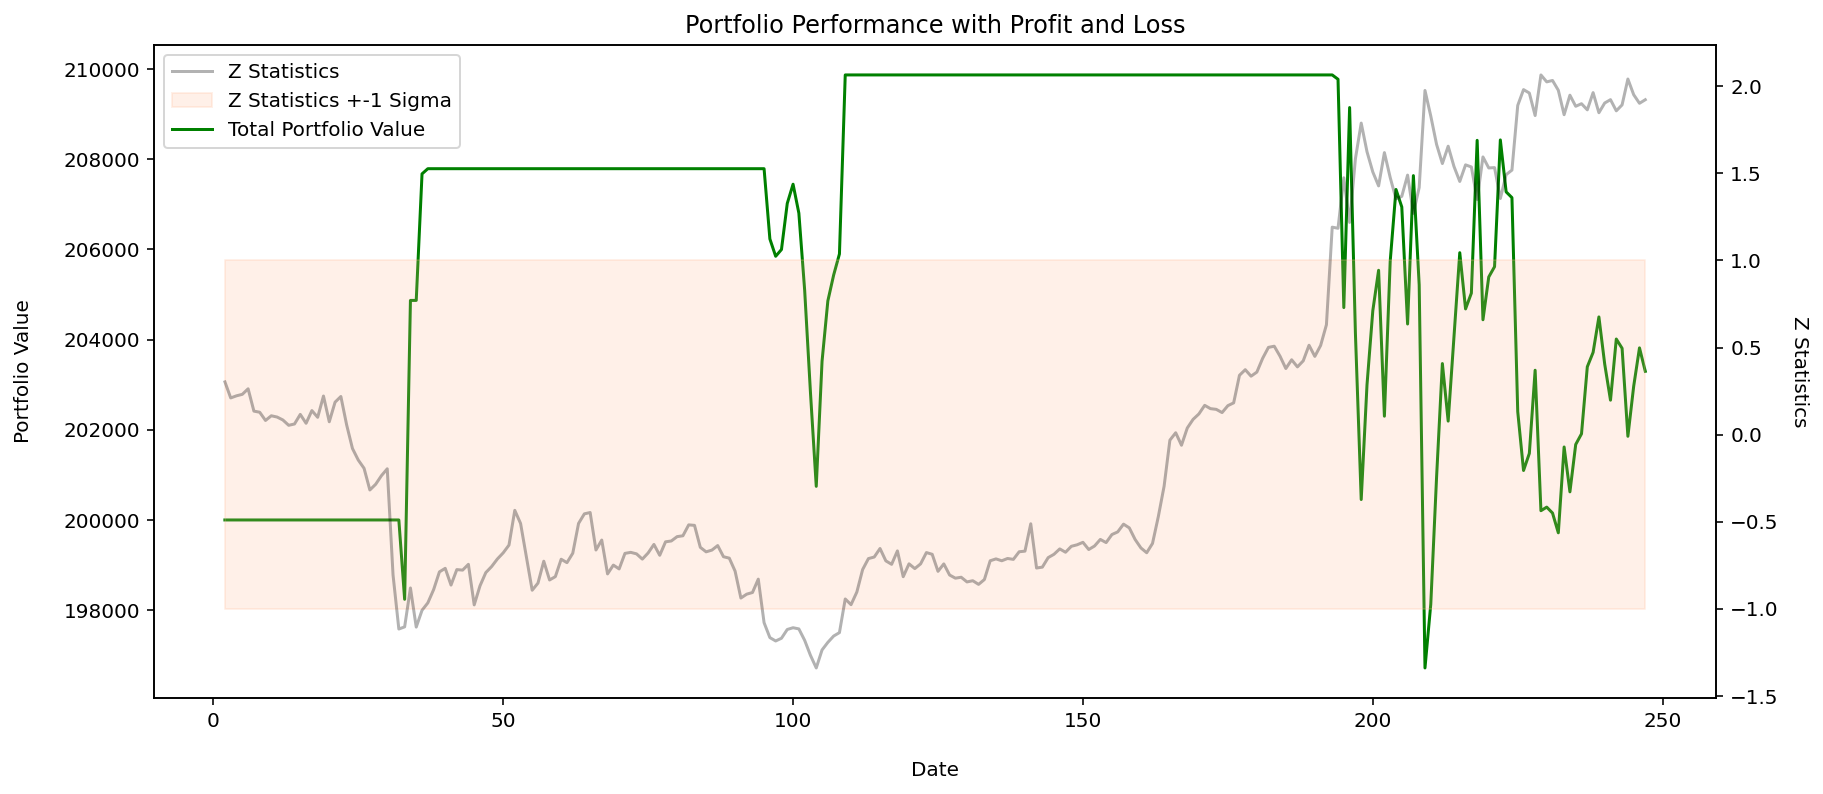

In [50]:
# plot the asset value change of the portfolio and pnl along with z-score
fig = plt.figure(figsize=(14,6),)
ax = fig.add_subplot(111)
ax2 = ax.twinx()

l1, = ax.plot(portfolio['total asset'], c='g')
l2, = ax2.plot(portfolio['z'], c='black', alpha=0.3)

b = ax2.fill_between(portfolio.index,portfolio['z upper limit'],\
                portfolio['z lower limit'], \
                alpha=0.2,color='#ffb48f')

ax.set_ylabel('Portfolio Value')
ax2.set_ylabel('Z Statistics',rotation=270)
ax.yaxis.labelpad=15
ax2.yaxis.labelpad=15
ax.set_xlabel('Date')
ax.xaxis.labelpad=15
plt.title('Portfolio Performance with Profit and Loss')
plt.legend([l2,b,l1],['Z Statistics',
                      'Z Statistics +-1 Sigma',
                      'Total Portfolio Value'],loc='upper left');
plt.savefig('chart8', dpi=400);

In [51]:
#portfolio = pd.read_csv('portfolio.csv')

In [52]:
# calculate CAGR
final_portfolio = portfolio['total asset'].iloc[-1]
final_portfolio

203296.7047767

In [53]:
profit = final_portfolio - 2*initial_capital
profit

3296.704776700004

In [54]:
roi = (profit / (2*initial_capital))*100
roi

1.648352388350002

In [55]:
# delta = (portfolio.index[-1] - portfolio.index[0]).days
delta = (portfolio.index[-1] - portfolio.index[0])
print('Number of days = ', delta)

Number of days =  245


In [56]:
YEAR_DAYS = 365
returns = (final_portfolio/initial_capital) ** (YEAR_DAYS/delta) - 1
print('CAGR = {:.3f}%' .format(returns * 100))

CAGR = 187.774%
